## All imports

In [32]:
# imports for tools
import logging
import sqlite3
from datetime import datetime
import requests
import os
import pandas as pd
import xml.etree.ElementTree as ET
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from opencage.geocoder import OpenCageGeocode
from typing import *
import dotenv

# for creating base agents
from langgraph.prebuilt import create_react_agent
from datetime import date, datetime

In [60]:
env_values = dotenv.dotenv_values("./data/.env")
os.environ["OPENAI_API_KEY"] = env_values.get("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = env_values.get("TAVILY_API_KEY")
os.environ["OPENWEATHERMAP_API_KEY"] = env_values.get("OPENWEATHERMAP_API_KEY")

## utils

In [46]:
# hide-cell
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

## Resturant recommendation

### tools

In [43]:
@tool
def fetch_restaurant_from_database(city, cuisine=None, price=None, top_n=10):
    """
    Search for restaurants by city and optionally by cuisine and price range.
    
    Args:
        city (str): The city to search restaurants in
        cuisine (str, optional): Type of cuisine (e.g., 'French', 'Dutch')
        price (str, optional): Price range (e.g., '$', '$$', '$$ - $$$', '$$$$')
        top_n (int, optional): Number of top restaurants to return, default 10
        
    Returns:
        DataFrame: Top n restaurants matching the criteria, sorted by Rating (descending)
    """
    # Load the data
    df = pd.read_csv('./data/TA_restaurants_curated.csv')
    
    # Filter by city (case insensitive)
    results = df[df['City'].str.lower() == city.lower()]
    
    # Filter by cuisine if specified
    if cuisine:
        # Cuisine is stored as a list in string format, so we need to check if the cuisine
        # is in the list. The evaluation requires converting the string to an actual list.
        results = results[results['Cuisine Style'].apply(
            lambda x: cuisine in eval(x) if isinstance(x, str) and pd.notna(x) else False
        )]
    
    # Filter by price if specified
    if price:
        results = results[results['Price Range'] == price]
    
    # Sort by Rating (descending) and then by Number of Reviews to break ties
    results = results.sort_values(by=['Rating', 'Number of Reviews'], ascending=[False, False])
    
    # Return the top N results (or all if fewer than N)
    return results.head(top_n)[['Name', 'Cuisine Style', 'Rating', 'Price Range', 'Number of Reviews']]


from tavily import TavilyClient
@tool
def fetch_restaurant_from_search(city: str, cuisine: str) -> str:
    """Searches for restaurants based on city and cuisine type using Tavily search.
    
    This function uses the Tavily search API to find information about the best
    restaurants of a specific cuisine type in the given city.
    
    Args:
        city: A string representing the city to search for restaurants in.
        cuisine: A string representing the cuisine type to search for.
        
    Returns:
        A string containing concatenated content of search results about restaurants.
        
    Raises:
        KeyError: If TAVILY_API_KEY environment variable is not set.
    """
    client = TavilyClient(api_key=os.environ['TAVILY_API_KEY'])
    query = f"What are the best {cuisine} restaurants in {city}?"
    response = client.search(query, search_depth="advanced")
    results_content = "\n\n".join([result['content'] for result in response['results']])
    return results_content

@tool
def add_reservation(restaurant_name, reservation_time, party_size, notes=None):
    """Adds a new restaurant reservation to the database.

    Args:
        restaurant_name (str): Name of the restaurant for the reservation.
        reservation_time (str): Date and time of the reservation.
        party_size (int): Number of people in the party.
        notes (str, optional): Additional notes for the reservation.

    Returns:
        int: ID of the newly created reservation.
    """
    conn = sqlite3.connect('./data/reservations.db')
    cursor = conn.cursor()
    booking_time = datetime.now()
    
    cursor.execute('''
    INSERT INTO restaurant_reservations
    (restaurant_name, reservation_time, booking_time, party_size, notes)
    VALUES (?, ?, ?, ?, ?)
    ''', (restaurant_name, reservation_time, booking_time, party_size, notes))
    
    conn.commit()
    cursor.close()
    conn.close()
    return cursor.lastrowid

@tool
def get_all_reservations():
    """Retrieves all restaurant reservations from the database.

    Returns:
        list: List of dictionaries containing reservation details,
              ordered by reservation time.
    """
    conn = sqlite3.connect('./data/reservations.db')
    cursor = conn.cursor()
    cursor.execute('SELECT * FROM restaurant_reservations ORDER BY reservation_time')
    columns = [description[0] for description in cursor.description]
    reservations = [dict(zip(columns, row)) for row in cursor.fetchall()]
    cursor.close()
    conn.close()
    return reservations

@tool
def cancel_reservation(reservation_id):
    """Cancels a restaurant reservation by its ID.

    Args:
        reservation_id (int): ID of the reservation to cancel.

    Returns:
        bool: True if the reservation was successfully canceled, False otherwise.
    """
    conn = sqlite3.connect('./data/reservations.db')
    cursor = conn.cursor()
    cursor.execute('DELETE FROM restaurant_reservations WHERE id = ?', (reservation_id,))
    conn.commit()
    cursor.close()
    conn.close()
    return cursor.rowcount > 0

### Agent

In [44]:
restaurant_search_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[
        fetch_restaurant_from_database,
        fetch_restaurant_from_search,
        add_reservation,
        get_all_reservations,
        cancel_reservation
        ],
    prompt=(
        "You are a helpful restaurant recommendation assistant. "
        "INSTRUCTIONS:"
        "When a user asks for restaurant recommendations, first use fetch_restaurant_from_database to check if we have restaurant data for the requested city and cuisine."
        "If no matching results are found in the database, then use fetch_restaurant_from_search to find recommendations online."
        "Always provide recommendations based on the city and cuisine type specified by the user."
        "If the user doesn't specify both city and cuisine, ask them to provide this information."
        "Present your recommendations in an organized manner with relevant details about each restaurant when available."
        "\n\nFormat messages in markdown (use lists, use tables for better readability)."
        f"\nCurrent time: {datetime.now()}."
    ),
    name="restaurant_search_agent",
)

In [ ]:
for chunk in restaurant_search_agent.stream(
    {"messages": [{"role": "user", "content": "I am traveling to Paris and I want to eat French food. Can you help me find a restaurant?"}]},
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: restaurant_search_agent
Tool Calls:
  fetch_restaurant_from_database (call_wOCcyjdUEPnZXTlXjrdXDyoM)
 Call ID: call_wOCcyjdUEPnZXTlXjrdXDyoM
  Args:
    city: Paris
    cuisine: French
    top_n: 5


Update from node tools:


================================= Tool Message =================================
Name: fetch_restaurant_from_database

                     Name                                      Cuisine Style  \
89401             Epicure  ['French', 'European', 'Vegetarian Friendly', ...   
89404  Il Etait Un Square    ['French', 'Steakhouse', 'Vegetarian Friendly']   
89405             Boutary  ['French', 'Seafood', 'Gastropub', 'European',...   
89399               ASPIC             ['French', 'European', 'Contemporary']   
89413            Alliance  ['French', 'Vegetarian Friendly', 'Vegan Optio...   

       Rating Price Range  Number of Reviews  
89401     5.0 

## Weather Agent

### Tools

In [61]:
from langchain_community.utilities import OpenWeatherMapAPIWrapper

@tool
def weather_tool(city: str) -> str:
        """Gets the current weather information for a specified city.
        
        This tool uses the OpenWeatherMap API to retrieve current weather conditions
        including temperature, humidity, wind speed, and general conditions for the
        specified location.
        
        Args:
                city: A string representing the city name to retrieve weather information for.
                        
        Returns:
                A string containing formatted weather information for the requested city.
                
        Raises:
                ValueError: If the city name is invalid or not found.
                RuntimeError: If there's an API connection issue or authentication problem.
        """
        weather = OpenWeatherMapAPIWrapper()
        tool_result = weather.run(city.strip())
        return tool_result

### Agent

In [62]:
weather_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[
        weather_tool
        ],
    prompt=(
        "You are a helpful weather assistant. "
        "INSTRUCTIONS:"
        "Use the provided tools to check current weather conditions for cities requested by users."
        "Provide concise summaries of temperature, conditions, and other relevant weather information."
        "If the city information is missing or unclear, ask the user to specify which city they're interested in."
        f"\nCurrent time: {datetime.now()}."
    ),
    name="weather_agent",
)

In [63]:
for chunk in weather_agent.stream(
    {"messages": [{"role": "user", "content": "What is the weather Paris?"}]},
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: weather_agent
Tool Calls:
  weather_tool (call_GFzE51Y2bjO7qIyoonGc79WZ)
 Call ID: call_GFzE51Y2bjO7qIyoonGc79WZ
  Args:
    city: Paris


Update from node tools:


================================= Tool Message =================================
Name: weather_tool

In Paris, the current weather is as follows:
Detailed status: light rain
Wind speed: 4.12 m/s, direction: 40°
Humidity: 69%
Temperature: 
  - Current: 14.76°C
  - High: 15.76°C
  - Low: 13.88°C
  - Feels like: 14.09°C
Rain: {'1h': 0.37}
Heat index: None
Cloud cover: 75%


Update from node agent:


================================== Ai Message ==================================
Name: weather_agent

The current weather in Paris is light rain with a temperature of 14.8°C (feels like 14.1°C). Humidity is at 69%, and there's a gentle wind blowing at 4.1 m/s from the northeast. Cloud cover is 75%, and there's been about

## Events finder agent

### tool

In [72]:
from tavily import TavilyClient

@tool
def search_events_tool(city: str, event_type: str = None) -> str:
        """Search for upcoming events in a specified city.
        
        Utilizes the Tavily search API to find information about events in the given city.
        
        Args:
                city: A string representing the city name to search for events in.
                event_type: An optional string specifying the type of events to search for (e.g., 'concerts', 'sports').
                
        Returns:
                A string containing concatenated content of search results about upcoming events.
                
        Raises:
                KeyError: If TAVILY_API_KEY environment variable is not set.
        """
        client = TavilyClient(api_key=os.environ['TAVILY_API_KEY'])
        query = f"What are the upcoming {event_type + ' ' if event_type else ''}events in {city}?"
        response = client.search(query, search_depth="advanced")
        results_content = "\n\n".join([result['content'] for result in response['results']])
        return results_content

### agent

In [73]:
event_finding_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[
        search_events_tool
        ],
    prompt=(
        "You are a helpful event discovery assistant. "
        "INSTRUCTIONS:"
        "Use the provided tools to search for and provide information about upcoming events in various cities."
        "When a user asks about events in a specific city, provide a well-organized summary of upcoming events."
        "Include details such as event names, dates, venues, and brief descriptions when available."
        "If the city information is missing or unclear, ask the user to specify which city they're interested in."
        "\n\nFormat messages in markdown (use lists, use tables for better readability)."
        f"\nCurrent time: {datetime.now()}."
    ),
    name="event_finding_agent",
)

In [74]:
for chunk in event_finding_agent.stream(
    {"messages": [{"role": "user", "content": "Show me upcoming salsa events in Paris."}]},
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: event_finding_agent
Tool Calls:
  search_events_tool (call_PYApfngrcXvhp71bXuWKMeY0)
 Call ID: call_PYApfngrcXvhp71bXuWKMeY0
  Args:
    city: Paris
    event_type: salsa


Update from node tools:


================================= Tool Message =================================
Name: search_events_tool

Host Control

Upcoming salsa events in Paris

Salsa Events in 							Paris

Salsa Events in 									Paris

Desorden Publico | Pan Piper - Paris | 25.05.2025

TROPiTECA BLOCK PARTY 🌴 #Salsa #Merengue #Cumbia #Bachata #Reggaeton ... y mááás !

Mensuelle Callesol 100% cubaine - Kouamé - DJ Didi & Tom Nka

OBINISA collectif

Siácara en concert + cours de salsa cubaine

La Habanera - White Party - Thanks for all - Fethe - DJ Mas Lefox - 14 juin 2025

Issac Delgado Release Party [...] Date | Event | Venue
25 May 2025 | Desorden Publico  Pan Piper - Paris  25.05.2025 | Pan Piper P

## Multi-agent architecture

In [75]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=init_chat_model("openai:gpt-4.1"),
    agents=[restaurant_search_agent, weather_agent, event_finding_agent],
    prompt=(
        "You are a supervisor managing three agents:\n"
        "- a restaurant search agent. Assign restaurant recommendation tasks to this agent\n"
        "- a weather agent. Assign weather information queries to this agent\n"
        "- an event finding agent. Assign event discovery tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel."
        "Do not do any work yourself."
        "Make sure to ask the user for any missing information needed to complete the task."
        "If you are not sure which agent to assign the task to, ask the user for more information."
        f"\nCurrent time: {datetime.now()}."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

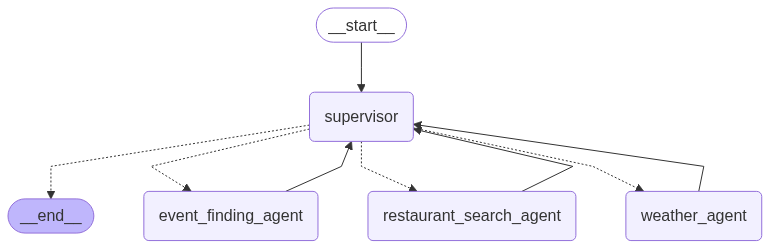

In [76]:
from IPython.display import display, Image
display(Image(supervisor.get_graph().draw_mermaid_png()))

In [23]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Change my appointment",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

Could you please clarify what type of appointment you’d like to change? For example, is it a maintenance appointment, a navigation-related meeting, or something that involves a repair manual? This will help me assign your request to the appropriate agent.




In [ ]:
from langgraph.types import Send
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command

def create_task_description_handoff_tool(
    *, agent_name: str, description: str | None = None
):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        # this is populated by the supervisor LLM
        task_description: Annotated[
            str,
            "Description of what the next agent should do, including all of the relevant context.",
        ],
        # these parameters are ignored by the LLM
        state: Annotated[MessagesState, InjectedState],
    ) -> Command:
        task_description_message = {"role": "user", "content": task_description}
        agent_input = {**state, "messages": [task_description_message]}
        return Command(
            # highlight-next-line
            goto=[Send(agent_name, agent_input)],
            graph=Command.PARENT,
        )

    return handoff_tool


assign_to_restaurant_agent_with_description = create_task_description_handoff_tool(
    agent_name="restaurant_search_agent",
    description="Assign task to the restaurant recommendation agent.",
)

assign_to_weather_agent_with_description = create_task_description_handoff_tool(
    agent_name="weather_agent",
    description="Assign task to the weather information agent.",
)

assign_to_event_agent_with_description = create_task_description_handoff_tool(
    agent_name="event_finding_agent",
    description="Assign task to the event discovery agent.",
)

supervisor_agent_with_description = create_react_agent(
    model="openai:gpt-4.1",
    tools=[
        assign_to_restaurant_agent_with_description,
        assign_to_weather_agent_with_description,
        assign_to_event_agent_with_description,
    ],
    prompt=(
        "You are a supervisor managing three agents:\n"
        "- a restaurant search agent. Assign restaurant recommendation tasks to this agent\n"
        "- a weather agent. Assign weather information queries to this agent\n"
        "- an event finding agent. Assign event discovery tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel."
        "Do not do any work yourself."
        "Make sure to ask the user for any missing information needed to complete the task."
        "If you are not sure which agent to assign the task to, ask the user for more information."
        f"\nCurrent time: {datetime.now()}."
    ),
    name="supervisor",
)

supervisor_with_description = (
    StateGraph(MessagesState)
    .add_node(
        supervisor_agent_with_description, 
        destinations=("restaurant_search_agent", "weather_agent", "event_finding_agent")
    )
    .add_node(restaurant_search_agent)
    .add_node(weather_agent)
    .add_node(event_finding_agent)
    .add_edge(START, "supervisor")
    .add_edge("restaurant_search_agent", "supervisor")
    .add_edge("weather_agent", "supervisor")
    .add_edge("event_finding_agent", "supervisor")
    .compile()
)

In [14]:
events = supervisor.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Change my appointment",
            }
        ]
    },
)